##Overview of project 
This notebook is steps in bold.
1. **Extract text from PDF Resumes**
2. Build an API for Angel.co for job listings (or Indeed API)
3. **Use Cosine similarity to match resumes to job postings**
4. **Review Scoring with Data Visualizations and comparisons**
5. Convert into a Streamlit app 

## Step 1. Convert pdf resume to text

In [ ]:
# Imports
import re
import string
from collections import Counter

import pandas as pd
import numpy as np
from gensim.summarization import keywords
import matplotlib.pyplot as plt

In [ ]:
#install pdf reader module
! pip install pdfminer.six

     |████████████████████████████████| 5.6MB 121kB/s 
     |████████████████████████████████| 2.7MB 33.4MB/s 


Download the test pdf resume.

In [ ]:
#click the below link and download pdf file from to your local machine
#'https://raw.githubusercontent.com/AVJdataminer/HireOne/master/data/Binoy_Dutt_Resume.pdf'


Then upload the pdf resume you downloaded to your colab content folder.

In [ ]:
from google.colab import files

uploaded = files.upload() # then browse, select the files. It's then uploaded

# uploaded is now a dict containing "filename" -> Content

Convert the pdf resume to text strings and print the results.

In [ ]:
from pdfminer.high_level import extract_text

#test out reading one pdf file
text = extract_text('Binoy_Dutt_Resume.pdf')
text

## **Step 2. Still not working , ignore this section for now.** -  Create an Angel.co job listing API 

In [ ]:
#install selenium
#! pip install selenium

     |████████████████████████████████| 911kB 2.7MB/s 


Installing the chromium webdriver and adjusting some options such that it does not crash in google colab.

In [ ]:
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
driver =webdriver.Chrome('chromedriver',chrome_options=chrome_options)

In [ ]:
#Another set of tools to try to get API query to work in Google Colab
!pip install kora -q
from kora.selenium import wd
wd.get("https://www.webite-url.com")

Build the API query function first.

In [ ]:
def get_results(query, type_=None, stage=None, tech=None):
    
#     tech is possible only if type not None, same for others

    if type_:
        type_ = type_.replace(' ', '+')
        url = 'https://angel.co/companies' + '?company_types[]=' + type_
        if stage:
            url = url + '&stage=' + stage
            if tech:
                url = url + '&teches[]=' + tech
    else:  
        url = 'https://angel.co/companies' 

    options = webdriver.ChromeOptions()
    options.add_argument('headless')
    
    driver = webdriver.Chrome(options=None)
    driver.set_window_position(3000,0)
    driver.get(url)
    time.sleep(5)
    
    search_box = driver.find_element_by_class_name("search-box")
    search_box.click()
    
    input_bar = driver.find_element_by_class_name('keyword-input')
    input_bar.send_keys(query)
    input_bar.send_keys(Keys.ENTER)
    time.sleep(3)

    while True:
        try:
            source = driver.page_source
            loadMoreButton = driver.find_element_by_class_name('more').click()
            time.sleep(4)
        except: 
            break
            
    driver.close()

    try:
        soup = bs.BeautifulSoup(source, 'lxml')
        result_list =  soup.find_all('div', {'class': 'results'})[0]
        results = result_list.find_all('div', {'data-_tn': 'companies/row'})
    except:
        print('Could not get results')
        return

    
    return results


def parse_results(results):
    df = pd.DataFrame(columns=['kind', 'link', 'name', 'pitch', 'joined', 'location', 'market', 'size', 'stage', 'raised'],
                  index=[0])
    for result in results[1:]:
        try:
            dic = {}
            try:
                dic['kind'] = result.a['data-type']
            except: dic['kind'] = None

            try:
                dic['link'] = result.a['href']
            except: dic['link'] = None

            try:
                dic['name'] = result.a['title']
            except: dic['name'] = None
                
            try:
                dic['website'] = result.find('div', {'data-column': 'website'}).text.split()[1]
            except: dic['website'] = None

            try:
                dic['pitch'] = result.find('div', {'class': 'pitch'}).text
            except: dic['pitch'] = None

            try:
                dic['joined'] = result.find('div', {'data-column': 'joined'}).text.split('Joined')[1].strip()
            except: dic['joined'] = None

            try:
                dic['location'] = result.find('div', {'data-column': 'location'}).text.split('Location')[1].strip()
            except: dic['location'] = None

            try:
                dic['market'] = result.find('div', {'data-column': 'market'}).text.split('Market')[1].strip()
            except: dic['market'] = None

            try:
                dic['size'] = result.find('div', {'data-column': 'company_size'}).text.split()[1]
            except: dic['size'] = None

            try:
                dic['stage'] = result.find('div', {'data-column': 'stage'}).text.split('Stage')[1].strip()
            except: dic['stage'] = None

            try:
                dic['raised'] = result.find('div', {'data-column': 'raised'}).text.split('Raised')[1].strip()
            except: dic['raised'] = None

            df = df.append(pd.DataFrame(dic, index=[0]))

        except: pass

    df = df.reset_index(drop=True)
    return df



def get_companies(query, type_=None, stage=None, tech=None):
    results = get_results(query, type_, stage, tech)
    if results:
        df = parse_results(results)
        return df

Set up the queries for different ML and AI topics.

In [ ]:
queries = ['artificial intelligence', 'machine learning', 'data science', 'big data', 'neural network', 
           'deep learning', 'natural language processing', 'transfer learning', 'reinforcement learning',
           'nlp', 'recurrent neural', 'convolution neural', 'data mining', 'data extraction', 
           'data engineering', 'web scraping', 'web scrape', 'web crawler', 'web crawling',
           'evolutionary computation', 'genetic algorithm', 'genetic programming', 'object recognition',
           'image understanding', 'speech processing', ' speech recognition', 'machine translation', 
           'time series', 'ai', 'intelligent machine', 'pattern recognition', 'computer vision']


types = ['Startup', 'VC Firm', 'Private Company', 'Incubator', 'SaaS', 'Mobile App', None]
stages = ['Seed', 'Series A', 'Series B', 'Series C', 'Acquired', None]
techs = ['Python', 'Javascript', 'HTML5', 'Java', 'CSS', None]


df = pd.DataFrame()
for type_ in types[2:]:
    for stage in stages:
        for tech in techs:
            for query in queries:
                print(query, type_, stage, tech)

                try:
                    companies = get_companies(query, type_, stage, tech)
                    companies['query'] = query
                    companies['type_'] = type_
                    companies['stage'] = stage
                    companies['tech'] = tech
                    print('Done')
                except Exception as e: 
                    companies = pd.DataFrame()
                    print('Could not get companies')
                    print('\n')
                    print(e)
                    print('\n')
                    pass

                try:
                    if df.empty:
                        df = companies
                    else:
                        df = df.append(companies)
                except:
                    print('Unable to append new data.')
                    pass
                    
            df = df.reset_index(drop=True)
            df.to_csv('ai_startups.csv')
            print(df.location.head())
                    
            
df = df.reset_index(drop=True)
df.to_csv('ai_startups.csv')

artificial intelligence Private Company Seed Python
Could not get companies


Message: unknown error: Chrome failed to start: exited abnormally.
  (unknown error: DevToolsActivePort file doesn't exist)
  (The process started from chrome location /usr/bin/chromium-browser is no longer running, so ChromeDriver is assuming that Chrome has crashed.)



machine learning Private Company Seed Python
Could not get companies


Message: unknown error: Chrome failed to start: exited abnormally.
  (unknown error: DevToolsActivePort file doesn't exist)
  (The process started from chrome location /usr/bin/chromium-browser is no longer running, so ChromeDriver is assuming that Chrome has crashed.)



data science Private Company Seed Python
Could not get companies


Message: unknown error: Chrome failed to start: exited abnormally.
  (unknown error: DevToolsActivePort file doesn't exist)
  (The process started from chrome location /usr/bin/chromium-browser is no longer running, so ChromeDriver is ass

AttributeError: ignored

##Step 3. Matching job listings to resumes with cosine similarity

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/AVJdataminer/HireOne/master/data/job_descriptions.csv', encoding = 'unicode_escape')
df.head()

,jobOrResumeDescription,role
0,: Artificial Intelligence / Machine Learning D...,Developer
1,: Data Scientist/Architect\n: 6+ months + Hig...,Data Scientist
2,": Data Analyst\n: Davidson, NC\n: 04+ Months\...",Data Analyst
3,: Big Data Architect or Data Scientist\n: New...,Data Scientist
4,": Data Engineer\n: Woonsocket, RI\n: 6+ Months...",Data Engineer


Clean up job description column.

In [ ]:
def clean_text(text):
    text = text.replace('\n', ' ')                # remove newline
    text = text.replace(':', ' ')
    return text
df['description'] = df.apply(lambda x: clean_text(x['jobOrResumeDescription']), axis=1)

Print first job desc

In [ ]:
df['description'].iloc[0]

"  Artificial Intelligence / Machine Learning Developer     Irving TX  Terms  Contract   Details             Bachelor's degree or 7-10 or more years of relevant  experience.     7+ years of server app development (design/develop/deploy).     3+ years of Python 3.x, experience in ML algorithms/data analytics.     5+ years of advanced SQL development (ER modeling, SQL scripts, stored procedures, functions, s) with RDBMS such as PostgreSQL/MS SQL Server.     3+ years on AWS S3, EC2, Serverless computing (Lambda).     3+ years of experience/familiarity with DevOps using Stash/Jenkins/Chef and Puppet.     Excellent communication  in interfacing with different cross-functional teams.         5+ years of experience in designing, building applications using .NET platform using C#, .NET Core, ORM, SQL, MS SQL Server, Visual Studio.     1+ years' experience in developing containerized Docker .net core apps."

Create a list from the cleaned job description column

In [ ]:
jd = df['description'].tolist()

Build model to tag each job description as a seperate document.


In [ ]:
import gensim
import gensim.downloader as api
from gensim import models
# Create the tagged document needed for Doc2Vec
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

train_data = list(create_tagged_document(jd))

print(train_data[:1])

[TaggedDocument(words="  Artificial Intelligence / Machine Learning Developer     Irving TX  Terms  Contract   Details             Bachelor's degree or 7-10 or more years of relevant  experience.     7+ years of server app development (design/develop/deploy).     3+ years of Python 3.x, experience in ML algorithms/data analytics.     5+ years of advanced SQL development (ER modeling, SQL scripts, stored procedures, functions, s) with RDBMS such as PostgreSQL/MS SQL Server.     3+ years on AWS S3, EC2, Serverless computing (Lambda).     3+ years of experience/familiarity with DevOps using Stash/Jenkins/Chef and Puppet.     Excellent communication  in interfacing with different cross-functional teams.         5+ years of experience in designing, building applications using .NET platform using C#, .NET Core, ORM, SQL, MS SQL Server, Visual Studio.     1+ years' experience in developing containerized Docker .net core apps.", tags=[0])]


Train the model on the job descriptions for matching later.

In [ ]:
# Init the Doc2Vec model
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

# Build the Volabulary
model.build_vocab(train_data)

# Train the Doc2Vec model
model.train(train_data, total_examples=model.corpus_count, epochs=model.epochs)

Let's look at an example of how it converts a list of words to a vector.

In [ ]:
print(model.infer_vector(['data', 'science','python']))

[-9.0049580e-04  9.3729707e-04  9.5215701e-03 -7.1332399e-03
  9.0731680e-03 -8.5485503e-03  4.2979093e-03 -4.2492119e-03
 -8.3840443e-03  3.9002204e-03 -3.4895353e-04  2.9707795e-03
  2.8806978e-03 -8.9825261e-03 -9.9531878e-03  1.2313742e-03
 -6.2231650e-03  6.6197319e-03  1.2553034e-03 -9.8728556e-03
 -4.0492681e-03 -3.0378737e-03  7.1065989e-03  4.3371865e-03
 -8.7247863e-03 -5.8196560e-03 -2.3256943e-03 -5.5077695e-03
 -8.3275102e-03 -4.8710499e-03  6.0714810e-05  8.4586637e-03
  8.4094070e-03 -4.1162362e-03 -3.1165923e-03 -3.5291738e-03
  8.7357946e-03 -3.0260670e-03  5.8570039e-03 -3.5897845e-03
 -5.4527395e-03  4.2740526e-03  5.5681253e-03  5.8630719e-03
 -5.9407563e-03 -6.8237288e-03 -3.7333095e-03  4.1679246e-03
 -5.9044352e-03  7.9363724e-03]


Here we apply the model to each job description in the corpus.

In [ ]:
data = []
for i in range(len(jd)):
    data.append(model.docvecs[i])

## Now let's load the text from our resume

In [ ]:
resume = pd.read_csv('https://raw.githubusercontent.com/AVJdataminer/HireOne/master/data/resumes.csv', encoding = 'unicode_escape')
resume.head()

,jobOrResumeDescription,role,sourceType,description
0,Â with around 5 years of experience in all p...,Data Scientist,resume,Â with around 5 years of experience in all p...
1,\n \nData scientist with a strong math backgro...,Data Scientist,resume,Data scientist with a strong math backgroun...
2,\n\n\n* Around 4+ years of experience in Data...,Data Scientist,resume,* Around 4+ years of experience in Data An...
3,\n\nExpert in logical and problem-solving wit...,Data Scientist,resume,Expert in logical and problem-solving with ...
4,Experienced with 2+ years of hands-on experie...,Data Scientist,resume,Experienced with 2+ years of hands-on experie...


We only need one resume to start with so let's select the first one and split into words to push into our model.

In [ ]:
r1 = resume['description'].iloc[0]

In [ ]:
resume = resume['description'].iloc[0].split()

Review the resulting vector.

In [ ]:
print(model.infer_vector(resume))

[-0.2703119   0.46140584  1.3335586   0.194047    0.3511251  -0.05135229
  1.2376658   1.104154    0.6905708  -0.66995645  0.00775168  1.7607471
 -0.56709665  0.71579945  1.4739642  -0.98076457 -0.70780426  0.93041635
 -0.38668808  0.03639724 -0.569789    0.30209452  1.1538218  -0.1179663
 -0.64267266 -0.57093453  0.14116059 -0.3806373   0.542782   -0.4670417
 -0.9182177  -0.00489526  2.1500022  -0.5747738   0.09500379 -0.12688264
  0.07573358  0.37014386 -1.56851     0.15511167 -0.06379291 -0.63691014
  0.957231    1.1769577  -1.1278763   0.05250629  0.93851274  0.62922686
 -0.03870421 -0.44639188]


In [ ]:
resume_vect = model.infer_vector(resume)

## Compare our resume to the job descriptions using PCA

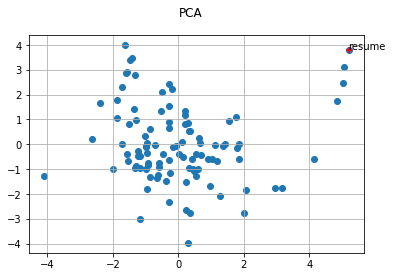

In [ ]:
def plot_pca(data):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2) #, whiten=True
    X = pca.fit_transform(data)
    xs,ys =X[:,0], X[:,1]
    plt.scatter(X[:,0], X[:,1])
    plt.scatter(xs[-1], ys[-1], c='Red', marker='+')
    plt.text(xs[-1], ys[-1],'resume')
    plt.grid()
    plt.suptitle('PCA')
    #plt.savefig('distance_PCA_improved.png')
    plt.show()
plot_pca(data)

## Calculate the cosine distances between our resume and each of the job descriptions

In [ ]:
from sklearn.metrics.pairwise import cosine_distances
cos_dist =[]
for i in range(len(data)):
    cos_dist.append(float(cosine_distances(resume_vect[0:].reshape(1,-1),data[i].reshape(1,-1))))

create a key words list for each job description

In [ ]:
key_list =[]

for j in jd:
    key =''
    for word in keywords(j).split('\n'):
        key += '{} '.format(word)
    key_list.append(key)

Create a nice data frame to put the scores and keywords together. Print out the first 10 lowest scores. Those jobs will the most similar to the resume.

In [ ]:
role = df['role'].tolist()
summary = pd.DataFrame({
        'Role Title': role,
        'Cosine Distances': cos_dist,
        'Keywords': key_list,
        'Job Description': jd
    })
z = summary.sort_values(by ='Cosine Distances', ascending=True)
z.head(10)

,Role Title,Cosine Distances,Keywords,Job Description
34,Data Scientist,0.408452,knowledge engineer experience learning data th...,- Data Scientist / Data Engineer - Chica...
35,Data Scientist,0.493039,knowledge experience learning scientist theano,"Data Scientist Chicago, IL Contract &..."
20,Data Scientist,0.605699,experience data lead leading time bdm field di...,Big Data Lead Raritan- NJ -12 months ...
30,Data Scientist,0.616657,experience experiments data models model model...,"Data Scientist Richardson, TX Full T..."
98,Data Engineer,0.632020,computational high computing numerical methods...,Applied Computational Mathematician / Engineer...
76,Data Analyst,0.661276,solutions like perform alternative solution pr...,"Sr. Business Analyst UC Innovation - Irvine, C..."
72,Data Analyst,0.680710,data experience including providing business m...,Senior Healthcare Data Analyst Advantmed98 re ...
24,Data Scientist,0.688905,experience data business solutions strong team...,"-Lead BI - Cheektowaga, NY -Full Time ..."
0,Developer,0.692190,years developer development developing sql ser...,Artificial Intelligence / Machine Learning D...
37,Data Engineer,0.719788,data processing process models good solutions ...,"Big Data Architect DE, PA, NJ, NYC, MA s (50-6..."


Let's print the first job description and our resume text to visually compare.

In [ ]:
z['Job Description'].iloc[0]

'   - Data Scientist / Data Engineer    - Chicago, IL    - Long Term  Exp Req  - 8+ Years        -      Senior data scientist / engineer      Financial Domain Knowledge & experience     Strong Experience in AI related      Knowledge & exposure in rendering ML functionality     Understanding  AI/Deep Learning algorithm such as CNN, RNN, LSTM     Experience in building AI based NLP and OCR solution using Keras, Google Tensorflow, Theano, Caffe 2 etc? '

In [ ]:
r1

"Â\x95  with around 5 years of experience in all phases of diverse   specializing in Data Science, Big Data, Azure Machine Learning, Google Cloud and Tableau, using Cloud based infrastructure.   Â\x95 ed on analyzing large datasets on distributed databases and developing Machine Learning algorithms to gain operational insights and present them to the leadership.   Â\x95 Extensively ed on Data preparation, exploratory analysis, Feature engineering using supervised and unsupervised modeling.   Â\x95 Experienced the full software life cycle in SDLC, Agile and Scrum methodologies.   Â\x95 Expert in using of statistical  and programming languages (R, Python, C, C++, Java, SQL, UNIX)   Â\x95 Adapted statistical programming languages like R and Python   Â\x95 Well-versed with Linear/non-linear, regression and classification modeling predictive algorithms.   Â\x95 Actively involved in model selection, statistical analysis using SAS and Gretl statistical tool.   Â\x95 Created dashboards as part


Let's test it out on another resume or dataset.

In [ ]:
df1 = pd.read_csv('https://raw.githubusercontent.com/JimKing100/techsearch/master/data/techsearch_p1.csv')
df1 = df1.drop(df1.columns[0], axis=1)
df2 = pd.read_csv('https://raw.githubusercontent.com/JimKing100/techsearch/master/data/techsearch_p2.csv')
df2 = df2.drop(df2.columns[0], axis=1)
both_df = pd.concat([df1, df2], ignore_index=True)

In [ ]:
both_df.head()

,job_title,company,location,description,counts,city,job,low_salary,high_salary
0,Data Scientist (All Levels) - Santa Clara,LeanTaaS,"Santa Clara, CA 95050",Help build technology that saves lives!\n\nWe'...,1259,San Jose,data scientist,NaN,NaN
1,Data Scientist (Intern) - United States,Cisco Careers,"San Jose, CA","What You‚Äôll DoAcquire, clean and structure d...",1259,San Jose,data scientist,NaN,NaN
2,Data Scientist,Stanford University,"Stanford, CA",Data Scientist (Data Analyst 2)\nJob Family: I...,1259,San Jose,data scientist,NaN,NaN
3,"Data Scientist in Santa Clara, CA (corp-corp c...",Advantine Technologies,"Santa Clara, CA",Job Description\n\nTitle : Data Scientist\nLoc...,1259,San Jose,data scientist,NaN,NaN
4,Data Scientist,Palo Verde Consulting,"Campbell, CA 95008","Job Title: Data ScientistLocation: Campbell, C...",1259,San Jose,data scientist,150000.0,210000.0


If you feel like you've got it, go ahead apply the steps we used up above on the job descriptions in this new data.

In [ ]:
both_df.shape

(7827, 9)

## Step 5. Build a Streamlit.io App from model

Starting with running the demo app.

Install streamlit module, ignore the warning about the wrong version.

In [ ]:
!pip install streamlit -q

     |████████████████████████████████| 7.1MB 2.6MB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 112kB 47.9MB/s 
     |████████████████████████████████| 4.4MB 38.1MB/s 
     |████████████████████████████████| 122kB 47.4MB/s 
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.3.4 which is incompatible.


Install ngrok helper module

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -qq ngrok-stable-linux-amd64.zip

--2020-07-29 21:06:57--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.5.250.138, 52.21.101.90, 54.152.45.100, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.5.250.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  12.9MB/s    in 1.0s    

2020-07-29 21:06:58 (12.9 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]



**Use the output of this command as the link to your Streamlit app.**

In [ ]:
#This cell makes the working link after last cell is run.
get_ipython().system_raw('./ngrok http 8501 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://19a0218f885c.ngrok.io


Get the Streamlit demo app running. **Ignore the output urls from this** 

In [ ]:
!streamlit hello


  Welcome to Streamlit. Check out our demo in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.231.115.65:8501

  Ready to create your own Python apps super quickly?
  Just head over to https://docs.streamlit.io

  May you create awesome apps!

  Stopping...


Now, go back and click on the link in the previous cell that ends in 'ngrok.io' to view the demo in your browser.

- When you are done reviewing the demo stop this cell by clicking on the stop button.
